# Project Check-In Week 10: Neural Networks

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
# Import data
data = pd.read_excel('../Data/clean_data.xlsx')
data.head()

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In [ ]:
# List of genres to subset
genres = ["chicago-house", "cantopop"]

# Subset the data to only include the specified genres
data = data.loc[data['track_genre'].isin(genres)]

In [ ]:
#remove categoical variables
data_clean = data[["loudness", "energy", "acousticness", "instrumentalness", "valence", "danceability"]]
data_clean.head()

,loudness,energy,acousticness,instrumentalness,valence,danceability
11053,-13.070,0.505,0.753,0.199000,0.570,0.576
11054,-14.684,0.228,0.834,0.000805,0.161,0.577
11055,-15.395,0.479,0.732,0.059800,0.301,0.641
11056,-15.309,0.210,0.769,0.000477,0.268,0.613
11057,-10.980,0.370,0.825,0.000005,0.465,0.646


In [ ]:
#number of genre
number_genre = data['track_genre'].nunique()
number_genre

2

In [ ]:
#convert genre to integers

# Create a mapping dictionary
unique_classes = list(set(data['track_genre']))
class_to_int = {cls: idx + 1 for idx, cls in enumerate(unique_classes)}

# Apply the mapping
encoded = [class_to_int[cls] for cls in data['track_genre']]

In [ ]:
#Convert X, Y to arrays
y = np.array(encoded)
X = data_clean

In [ ]:
#normalize x to 0-1
from sklearn.preprocessing import MinMaxScaler

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Normalize the DataFrame
X_norm = scaler.fit_transform(X)
X_norm = np.array(X_norm)

In [ ]:
#check dimensions
print(y.shape)
print(X_norm.shape)

(1996,)
(1996, 6)


In [ ]:
from sklearn.model_selection import train_test_split


X_temp, X_test, y_temp, y_test = train_test_split(
    X_norm, y, test_size=0.2, random_state=123, stratify=y)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, test_size=0.07, random_state=123, stratify=y_temp)


Implementing Multilayer Perception

In [ ]:
##########################
### MODEL
##########################

def sigmoid(z):
    return 1. / (1. + np.exp(-z))


def int_to_onehot(y, num_labels):

    ary = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y):
        ary[i, val-1] = 1

    return ary


class NeuralNetMLP:

    def __init__(self, num_features, num_hidden, num_classes, random_seed=123):
        super().__init__()

        self.num_classes = num_classes

        # hidden
        rng = np.random.RandomState(random_seed)

        self.weight_h = rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden, num_features))
        self.bias_h = np.zeros(num_hidden)

        # output
        self.weight_out = rng.normal(
            loc=0.0, scale=0.1, size=(num_classes, num_hidden))
        self.bias_out = np.zeros(num_classes)

    def forward(self, x):
        # Hidden layer
        # input dim: [n_examples, n_features] dot [n_hidden, n_features].T
        # output dim: [n_examples, n_hidden]
        z_h = np.dot(x, self.weight_h.T) + self.bias_h
        a_h = sigmoid(z_h)

        # Output layer
        # input dim: [n_examples, n_hidden] dot [n_classes, n_hidden].T
        # output dim: [n_examples, n_classes]
        z_out = np.dot(a_h, self.weight_out.T) + self.bias_out
        a_out = sigmoid(z_out)
        return a_h, a_out

    def backward(self, x, a_h, a_out, y):

        #########################
        ### Output layer weights
        #########################

        # onehot encoding
        y_onehot = int_to_onehot(y, self.num_classes)

        # Part 1: dLoss/dOutWeights
        ## = dLoss/dOutAct * dOutAct/dOutNet * dOutNet/dOutWeight
        ## where DeltaOut = dLoss/dOutAct * dOutAct/dOutNet
        ## for convenient re-use

        # input/output dim: [n_examples, n_classes]
        d_loss__d_a_out = 2.*(a_out - y_onehot) / y.shape[0]

        # input/output dim: [n_examples, n_classes]
        d_a_out__d_z_out = a_out * (1. - a_out) # sigmoid derivative

        # output dim: [n_examples, n_classes]
        delta_out = d_loss__d_a_out * d_a_out__d_z_out # "delta (rule) placeholder"

        # gradient for output weights

        # [n_examples, n_hidden]
        d_z_out__dw_out = a_h

        # input dim: [n_classes, n_examples] dot [n_examples, n_hidden]
        # output dim: [n_classes, n_hidden]
        d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out)
        d_loss__db_out = np.sum(delta_out, axis=0)


        #################################
        # Part 2: dLoss/dHiddenWeights
        ## = DeltaOut * dOutNet/dHiddenAct * dHiddenAct/dHiddenNet * dHiddenNet/dWeight

        # [n_classes, n_hidden]
        d_z_out__a_h = self.weight_out

        # output dim: [n_examples, n_hidden]
        d_loss__a_h = np.dot(delta_out, d_z_out__a_h)

        # [n_examples, n_hidden]
        d_a_h__d_z_h = a_h * (1. - a_h) # sigmoid derivative

        # [n_examples, n_features]
        d_z_h__d_w_h = x

        # output dim: [n_hidden, n_features]
        d_loss__d_w_h = np.dot((d_loss__a_h * d_a_h__d_z_h).T, d_z_h__d_w_h)
        d_loss__d_b_h = np.sum((d_loss__a_h * d_a_h__d_z_h), axis=0)

        return (d_loss__dw_out, d_loss__db_out,
                d_loss__d_w_h, d_loss__d_b_h)

In [ ]:
model = NeuralNetMLP(num_features=6,
                     num_hidden=50,
                     num_classes=number_genre)

Coding the neural network training loop

In [ ]:
num_epochs =50
minibatch_size = 100


def minibatch_generator(X, y, minibatch_size):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    for start_idx in range(0, indices.shape[0] - minibatch_size
                           + 1, minibatch_size):
        batch_idx = indices[start_idx:start_idx + minibatch_size]

        yield X[batch_idx], y[batch_idx]


# iterate over training epochs
for i in range(num_epochs):

    # iterate over minibatches
    minibatch_gen = minibatch_generator(
        X_train, y_train, minibatch_size)

    for X_train_mini, y_train_mini in minibatch_gen:

        break

    break

print(X_train_mini.shape)
print(y_train_mini.shape)

(100, 6)
(100,)


Defining a function to compute the loss and accuracy

The metric we are using for the loss function is mse

In [ ]:
def mse_loss(targets, probas, num_labels=number_genre):
    onehot_targets = int_to_onehot(targets, num_labels=num_labels)
    return np.mean((onehot_targets - probas)**2)


def accuracy(targets, predicted_labels):
    return np.mean(predicted_labels == targets)


_, probas = model.forward(X_valid)
mse = mse_loss(y_valid, probas)

predicted_labels = np.argmax(probas, axis=1)
acc = accuracy(y_valid, predicted_labels)

print(f'Initial validation MSE: {mse:.1f}')
print(f'Initial validation accuracy: {acc*100:.1f}%')

Initial validation MSE: 0.3
Initial validation accuracy: 0.0%


In [ ]:
def compute_mse_and_acc(nnet, X, y, num_labels=number_genre, minibatch_size=100):
    mse, correct_pred, num_examples = 0., 0, 0
    minibatch_gen = minibatch_generator(X, y, minibatch_size)

    for i, (features, targets) in enumerate(minibatch_gen):

        _, probas = nnet.forward(features)
        predicted_labels = np.argmax(probas, axis=1)

        onehot_targets = int_to_onehot(targets, num_labels=num_labels)
        loss = np.mean((onehot_targets - probas)**2)
        correct_pred += (predicted_labels == targets).sum()

        num_examples += targets.shape[0]
        mse += loss

    mse = mse/(i+1)
    acc = correct_pred/num_examples
    return mse, acc

In [ ]:
mse, acc = compute_mse_and_acc(model, X_valid, y_valid)
print(f'Initial valid MSE: {mse:.1f}')
print(f'Initial valid accuracy: {acc*100:.1f}%')

Initial valid MSE: 0.3
Initial valid accuracy: 0.0%


Getting Best Learning Rate

To find the best learning rate, we will increment the learning rate by 10/50 from 10e-5 and plot it against the loss. The optimal learning rate will be half of the max. learning rate where loss is the lowest.

In [ ]:
def train(model, X_train, y_train, X_valid, y_valid, num_epochs, initial_learning_rate=10e-5):
    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []
    lr = []

    # Initialize the learning rate
    learning_rate = initial_learning_rate

    for e in range(num_epochs):

        # Increment learning rate by 10/50 every epoch
        learning_rate += 10 / 50
        lr.append(learning_rate)

        # iterate over minibatches
        minibatch_gen = minibatch_generator(X_train, y_train, minibatch_size)

        for X_train_mini, y_train_mini in minibatch_gen:

            #### Compute outputs ####
            a_h, a_out = model.forward(X_train_mini)

            #### Compute gradients ####
            d_loss__d_w_out, d_loss__d_b_out, d_loss__d_w_h, d_loss__d_b_h = \
                model.backward(X_train_mini, a_h, a_out, y_train_mini)

            lambda_reg  = 0.01 # regularization strength
            #### Update weights w/ l2 regularization####
            model.weight_h -= learning_rate * (d_loss__d_w_h + lambda_reg * model.weight_h)
            model.bias_h -= learning_rate * d_loss__d_b_h  # No regularization on biases (usually)
            model.weight_out -= learning_rate * (d_loss__d_w_out + lambda_reg * model.weight_out)
            model.bias_out -= learning_rate * d_loss__d_b_out  # No regularization on biases (usually)

        #### Epoch Logging ####
        train_mse, train_acc = compute_mse_and_acc(model, X_train, y_train)
        valid_mse, valid_acc = compute_mse_and_acc(model, X_valid, y_valid)
        train_acc, valid_acc = train_acc * 100, valid_acc * 100
        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        epoch_loss.append(train_mse)
        print(f'Epoch: {e+1:03d}/{num_epochs:03d} '
              f'| Learning Rate: {learning_rate:.4f} '
              f'| Train MSE: {train_mse:.2f} '
              f'| Train Acc: {train_acc:.2f}% '
              f'| Valid Acc: {valid_acc:.2f}%')

    return epoch_loss, epoch_train_acc, epoch_valid_acc, lr

In [ ]:
np.random.seed(123) # for the training set shuffling

epoch_loss, epoch_train_acc, epoch_valid_acc, lr = train(
    model, X_train, y_train, X_valid, y_valid,
    num_epochs=50, initial_learning_rate=10e-5)

Epoch: 001/050 | Learning Rate: 0.2001 | Train MSE: 0.25 | Train Acc: 0.00% | Valid Acc: 0.00%
Epoch: 002/050 | Learning Rate: 0.4001 | Train MSE: 0.25 | Train Acc: 0.00% | Valid Acc: 0.00%
Epoch: 003/050 | Learning Rate: 0.6001 | Train MSE: 0.25 | Train Acc: 0.00% | Valid Acc: 0.00%
Epoch: 004/050 | Learning Rate: 0.8001 | Train MSE: 0.25 | Train Acc: 49.86% | Valid Acc: 50.00%
Epoch: 005/050 | Learning Rate: 1.0001 | Train MSE: 0.23 | Train Acc: 0.00% | Valid Acc: 0.00%
Epoch: 006/050 | Learning Rate: 1.2001 | Train MSE: 0.22 | Train Acc: 0.00% | Valid Acc: 0.00%
Epoch: 007/050 | Learning Rate: 1.4001 | Train MSE: 0.21 | Train Acc: 49.50% | Valid Acc: 49.00%
Epoch: 008/050 | Learning Rate: 1.6001 | Train MSE: 0.26 | Train Acc: 50.43% | Valid Acc: 47.00%
Epoch: 009/050 | Learning Rate: 1.8001 | Train MSE: 0.24 | Train Acc: 48.93% | Valid Acc: 50.00%
Epoch: 010/050 | Learning Rate: 2.0001 | Train MSE: 0.10 | Train Acc: 11.07% | Valid Acc: 16.00%
Epoch: 011/050 | Learning Rate: 2.2001 |

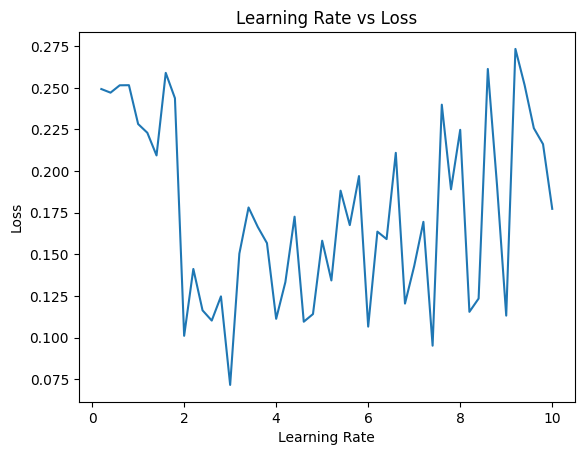

In [ ]:
plt.figure()
plt.plot (lr,epoch_loss)
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.title('Learning Rate vs Loss')
plt.show()

In [ ]:
min_loss = min(epoch_loss)
min_loss_index = epoch_loss.index(min_loss)
min_lr = lr[min_loss_index]/2
# optimal learning rate is 1/2 max. learning rate to prevent overfitting
print(min_lr)

1.5000500000000003


In [ ]:
def train(model, X_train, y_train, X_valid, y_valid, num_epochs,
          learning_rate=min_lr):

    epoch_loss_train = []
    epoch_loss_valid = []
    epoch_train_acc = []
    epoch_valid_acc = []

    for e in range(num_epochs):

        # iterate over minibatches
        minibatch_gen = minibatch_generator(
            X_train, y_train, minibatch_size)

        for X_train_mini, y_train_mini in minibatch_gen:

            #### Compute outputs ####
            a_h, a_out = model.forward(X_train_mini)

            #### Compute gradients ####
            d_loss__d_w_out, d_loss__d_b_out, d_loss__d_w_h, d_loss__d_b_h = \
                model.backward(X_train_mini, a_h, a_out, y_train_mini)

            #### Update weights ####
            model.weight_h -= learning_rate * d_loss__d_w_h
            model.bias_h -= learning_rate * d_loss__d_b_h
            model.weight_out -= learning_rate * d_loss__d_w_out
            model.bias_out -= learning_rate * d_loss__d_b_out

        #### Epoch Logging ####
        train_mse, train_acc = compute_mse_and_acc(model, X_train, y_train)
        valid_mse, valid_acc = compute_mse_and_acc(model, X_valid, y_valid)
        train_acc, valid_acc = train_acc*100, valid_acc*100
        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        epoch_loss_train.append(train_mse)
        epoch_loss_valid.append(valid_mse)
        print(f'Epoch: {e+1:03d}/{num_epochs:03d} '
              f'| Train MSE: {train_mse:.2f} '
              f'| Train Acc: {train_acc:.2f}% '
              f'| Valid Acc: {valid_acc:.2f}%'
              f'| Valid MSE: {valid_mse:.2f}')

    return epoch_loss_train, epoch_train_acc, epoch_valid_acc, epoch_loss_valid

In [ ]:
np.random.seed(123) # for the training set shuffling

epoch_loss_train, epoch_train_acc, epoch_valid_acc, epoch_loss_valid = train(
    model, X_train, y_train, X_valid, y_valid,
    num_epochs=50, learning_rate=min_lr)

Epoch: 001/050 | Train MSE: 0.07 | Train Acc: 3.07% | Valid Acc: 5.00%| Valid MSE: 0.08
Epoch: 002/050 | Train MSE: 0.06 | Train Acc: 2.14% | Valid Acc: 2.00%| Valid MSE: 0.06
Epoch: 003/050 | Train MSE: 0.05 | Train Acc: 3.29% | Valid Acc: 5.00%| Valid MSE: 0.06
Epoch: 004/050 | Train MSE: 0.04 | Train Acc: 3.36% | Valid Acc: 5.00%| Valid MSE: 0.05
Epoch: 005/050 | Train MSE: 0.04 | Train Acc: 3.07% | Valid Acc: 5.00%| Valid MSE: 0.05
Epoch: 006/050 | Train MSE: 0.04 | Train Acc: 2.86% | Valid Acc: 6.00%| Valid MSE: 0.05
Epoch: 007/050 | Train MSE: 0.04 | Train Acc: 2.36% | Valid Acc: 5.00%| Valid MSE: 0.05
Epoch: 008/050 | Train MSE: 0.03 | Train Acc: 2.36% | Valid Acc: 4.00%| Valid MSE: 0.04
Epoch: 009/050 | Train MSE: 0.03 | Train Acc: 2.07% | Valid Acc: 3.00%| Valid MSE: 0.03
Epoch: 010/050 | Train MSE: 0.03 | Train Acc: 1.29% | Valid Acc: 2.00%| Valid MSE: 0.04
Epoch: 011/050 | Train MSE: 0.03 | Train Acc: 1.50% | Valid Acc: 3.00%| Valid MSE: 0.04
Epoch: 012/050 | Train MSE: 0.03

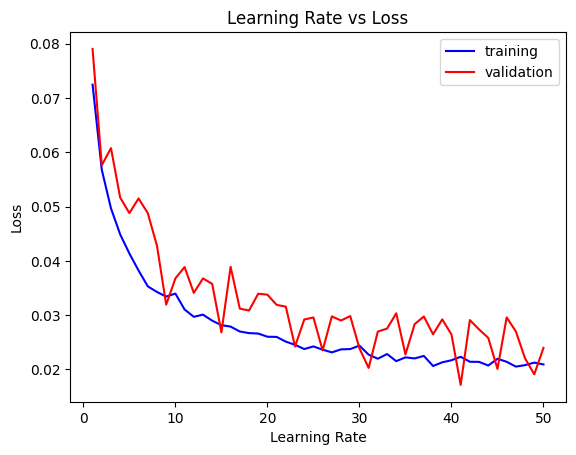

In [ ]:
plt.figure()
y = range(1, len(epoch_loss) + 1)
plt.plot (y, epoch_loss_train, color = 'blue', label = 'training')
plt.plot (y, epoch_loss_valid, color = 'red', label = 'validation')
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.title('Learning Rate vs Loss')
plt.legend()
plt.show()

#Loss for both training and validation are lowest at epoch is 50, thus 50 is a good number of iterations